In [1]:
pip install pyamg

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import scipy
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pyamg
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # High quality graphics
plt.rcParams['animation.html'] = 'html5'

import sys
import time

Example considered is of a 1D fin with the governing differential equation:

$$\frac{d^2 \theta}{dx^2} = m\theta$$

where,

$$\theta = \frac{T - T_\infty}{T_b - T_\infty}, \qquad m = \frac{hP}{kA_c}$$

with the boundary conditions

$$x = 0, T = T_b, \theta = 1$$

$$x = L, \frac{dT}{dx} = 0, \frac{d\theta}{dx} = 0$$

The central difference discretized equation is:

$$\theta_{i-1} - \left(2 + m\left(\Delta x\right)^2\right)\theta_{i} + \theta_{i+1} = 0$$

The actual solution is given by:

$$\theta = \frac{\cosh{m(L - x)}}{\cosh{mL}}$$

In [3]:
ht = 100
Dt = 0.005
kt = 398
mt = (ht*4)/(kt*Dt)

In [4]:
L = 0.3
nx = 2002
dx = L/(nx - 1)

print(f'Order of n2 - {(nx - 2)**2}\nOrder of ~3n - {3*(nx - 2)}')
print(f'\nSize (MB) - {8*(nx - 2)**2/(1024*1024)} (n2) vs {3*(nx - 2)/(1024*1024)} (~3n)')

Order of n2 - 4000000
Order of ~3n - 6000

Size (MB) - 30.517578125 (n2) vs 0.0057220458984375 (~3n)


In [5]:
Ae = np.ones(nx - 2)
Aw = np.ones(nx - 2)
Ae[-1] = 0
Aw[0] = 0
Ap = -np.ones(nx - 2)*(2 + mt*dx*dx)
Ap[-1] = -(1 + mt*dx*dx)

S = np.zeros(nx - 2)
S[0] = -1

d0 = Ap
du = Ae[:-1]
dl = Aw[1:]

A = scipy.sparse.diags([d0, du, dl], [0, 1, -1], format = 'csr')
print(A.toarray())

[[-2.00000452  1.          0.         ...  0.          0.
   0.        ]
 [ 1.         -2.00000452  1.         ...  0.          0.
   0.        ]
 [ 0.          1.         -2.00000452 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -2.00000452  1.
   0.        ]
 [ 0.          0.          0.         ...  1.         -2.00000452
   1.        ]
 [ 0.          0.          0.         ...  0.          1.
  -1.00000452]]


In [6]:
sol_dict = dict()

def update_sol(sol_name, t, u):
    sol_dict[sol_name] = dict()
    sol_dict[sol_name]['Time'] = t
    sol_dict[sol_name]['Solution'] = u

0.4095473289489746 s
dict_keys(['Direct solver'])


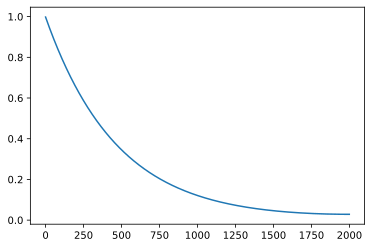

In [7]:
# Direct sparse solver
solver = 'Direct solver'

start = time.time()
A_inv = scipy.sparse.linalg.inv(A.tocsc())
T_sol = A_inv @ S
end = time.time() - start

update_sol(solver, end, T_sol)

print(f'{end} s')
print(sol_dict.keys())
plt.plot(T_sol)
plt.show()

0.0049915313720703125 s
dict_keys(['Direct solver', 'Scipy sparse solver'])


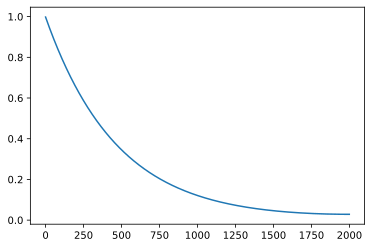

In [8]:
# Scipy sparse solver
solver = 'Scipy sparse solver'

start = time.time()
T_sol = scipy.sparse.linalg.spsolve(A, S)
end = time.time() - start

update_sol(solver, end, T_sol)

print(f'{end} s')
print(sol_dict.keys())
plt.plot(T_sol)
plt.show()

0.04511690139770508 s
dict_keys(['Direct solver', 'Scipy sparse solver', 'cg solver'])


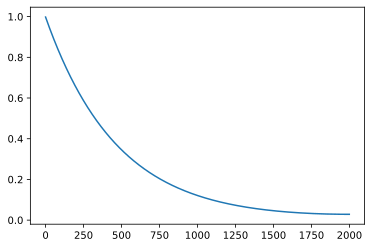

In [9]:
# cg solver
solver = 'cg solver'

start = time.time()
T_sol, err = scipy.sparse.linalg.cg(A, S)
end = time.time() - start

update_sol(solver, end, T_sol)

print(f'{end} s')
print(sol_dict.keys())
plt.plot(T_sol)
plt.show()

0.012558460235595703 s
dict_keys(['Direct solver', 'Scipy sparse solver', 'cg solver', 'amg solver'])


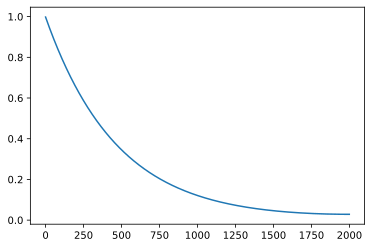

In [10]:
# amg solver
solver = 'amg solver'

start = time.time()
ml = pyamg.ruge_stuben_solver(A)
T_sol = ml.solve(S, tol = 1e-9, cycle = 'V')
end = time.time() - start

update_sol(solver, end, T_sol)

print(f'{end} s')
print(sol_dict.keys())
plt.plot(T_sol)
plt.show()

<AxesSubplot:xlabel='index', ylabel='Time'>

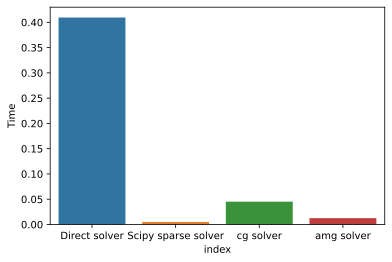

In [11]:
sol_df = pd.DataFrame(sol_dict).T.reset_index()
sns.barplot(data = sol_df, y = 'Time', x = 'index')

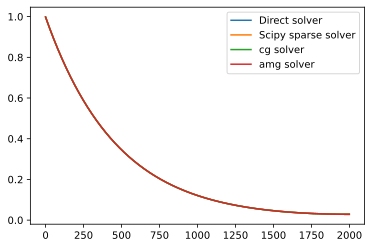

In [12]:
for row in sol_df.iterrows():
    plt.plot(row[1]['Solution'], label = row[1]['index'])
plt.legend()
plt.show()

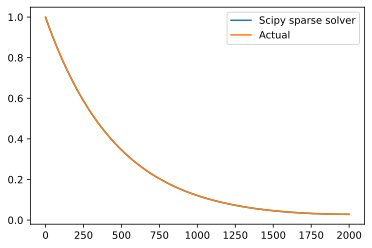

In [13]:
# Actual solution
m = mt**0.5
xs = np.linspace(0, L, 2002)
t_actual = np.cosh(m * (L - xs)) / np.cosh(m*L)
plt.plot(sol_dict['Scipy sparse solver']['Solution'], label = 'Scipy sparse solver')
plt.plot(t_actual, label = 'Actual')
plt.legend()
plt.show()

In [14]:
# #Gauss-Seidel OR
# it = 0
# err = 1000
# ϵ = 1e-8
# max_itr = 100
# β = 1.1

# tk = np.zeros(nx - 2) + 1
# while ϵ > err and it < max_itr:
#     tk1 = tk.copy()
#     for i in range(0, nx - 2):
#         if i == 0:
#             trhs = (1 + tk1[i+1])/(2 + mt*dx*dx)
#         elif i == nx - 3:
#             trhs = (tk1[i-1])/(1 + mt*dx*dx)
#         else:
#             trhs = (tk1[i-1] + tk1[i+1])/(2 + mt*dx*dx)
#         tk1[i] = trhs
#     err = np.linalg.norm(tk1 - tk, 2)
#     it += 1
# plt.plot(tk1)

In [15]:
time_sol = dict()
for n in range(102, 7003, 100):
    
    dx = L/(n - 1)
    Ae = np.ones(n - 2)
    Aw = np.ones(n - 2)
    Ae[-1] = 0
    Aw[0] = 0
    Ap = -np.ones(n - 2)*(2 + mt*dx*dx)
    Ap[-1] = -(1 + mt*dx*dx)

    S = np.zeros(n - 2)
    S[0] = -1
    
    d0 = Ap
    du = Ae[:-1]
    dl = Aw[1:]
    A = scipy.sparse.diags([d0, du, dl], [0, 1, -1], format = 'csr')

    time_sol[n] = dict()

    start = time.time()
    A_inv = scipy.sparse.linalg.inv(A.tocsc())
    T_sol = A_inv @ S
    end = time.time() - start
    time_sol[n]['Direct solver'] = end
    print('a', end = '')
    
    start = time.time()
    T_sol = scipy.sparse.linalg.spsolve(A, S)
    end = time.time() - start
    time_sol[n]['Scipy Sparse solver'] = end
    print('b', end = '')
    
    start = time.time()
    T_sol, err = scipy.sparse.linalg.cg(A, S)
    end = time.time() - start
    time_sol[n]['cg solver'] = end
    print('c', end = '')
    
    start = time.time()
    ml = pyamg.ruge_stuben_solver(A)
    T_sol = ml.solve(S, tol = 1e-9, cycle = 'V')
    end = time.time() - start
    time_sol[n]['amg solver'] = end
    
    print(n, end = ' ')

abc102 abc202 abc302 abc402 abc502 abc602 abc702 abc802 abc902 abc1002 abc1102 abc1202 abc1302 abc1402 abc1502 abc1602 abc1702 abc1802 abc1902 abc2002 abc2102 abc2202 abc2302 abc2402 abc2502 abc2602 abc2702 abc2802 abc2902 abc3002 abc3102 abc3202 abc3302 abc3402 abc3502 abc3602 abc3702 abc3802 abc3902 abc4002 abc4102 abc4202 abc4302 abc4402 abc4502 abc4602 abc4702 abc4802 abc4902 abc5002 abc5102 abc5202 abc5302 abc5402 abc5502 abc5602 abc5702 abc5802 abc5902 abc6002 abc6102 abc6202 abc6302 abc6402 abc6502 abc6602 abc6702 abc6802 abc6902 abc7002 

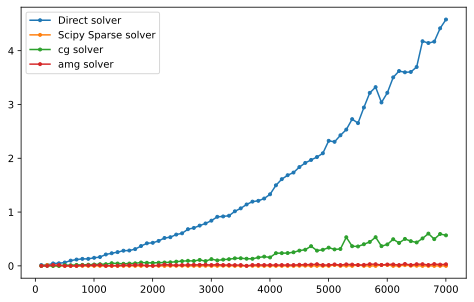

In [16]:
time_df = pd.DataFrame(time_sol).T
time_df.plot(kind = 'line', figsize = (8, 5), marker = 'o', markersize = 3)
# plt.ylim([0, 0.2])
plt.show()

One can notice the significant increase in solving time for the Direct solver compared to other sparse solvers.